In [1]:
import QNN as qnn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2024-09-18 17:45:26.971061: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-18 17:45:26.971075: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-18 17:45:26.971629: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


1 Physical GPUs, 1 Logical GPUs


In [2]:
def f1(x, eps=0.0):
    """The function f(x)= |x| + noise"""
    return np.abs(x) + eps * np.random.normal(size=x.shape)


def f2(x, eps=0.0):
    """The function f(x)=sin(x) + noise"""
    return np.sin(x) + eps * np.random.normal(size=x.shape)


def f3(x, eps=0.0):
    """The function f(x)=exp(x)+noise"""
    return np.exp(x) + eps * np.random.normal(size=x.shape)


def f4(x, eps=0.0):
    """The function f(x)=log(x+2*pi)+noise"""
    return np.log(x+2*np.pi) + eps * np.random.normal(size=x.shape)


def f5(x, eps=0.0):
    """The function f(x)=x^3+noise"""
    return x**3 + eps * np.random.normal(size=x.shape)

In [3]:
# Prepare your dataset
x = np.linspace(-np.pi, np.pi, 300).reshape(-1, 1)
F = [f1, f2, f3, f4, f5]
Y = np.array([f(x, eps=0.1) for f in F])

def min_max_normalize(data):
    min_val = data.min(axis=1, keepdims=True)
    max_val = data.max(axis=1, keepdims=True)
    return (data - min_val) / (max_val - min_val)

# Normalize each result individually
Y = min_max_normalize(Y)

In [4]:
abs_lr = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    end_learning_rate=0.001,
    power=2.0
)

trig_lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,  
    decay_steps=1000,              
    decay_rate=1                
)
    
exp_lr = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    end_learning_rate=0.0001,
    power=3.0
)

log_lr = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.95,
)

cube_lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,  
    decay_steps=1000,              
    decay_rate=0.9                
)
    
rates = [abs_lr, trig_lr, exp_lr, log_lr, cube_lr]

In [ ]:
# Train the model
results = []
layers = [2,3,2,2,2]
for i in range(5):
    results.append(qnn.train_model(x, Y[i], i+1, learning_rate=rates[i], num_layers=4, cutoff_dim=10, epochs=50))
H, M = zip(*results)

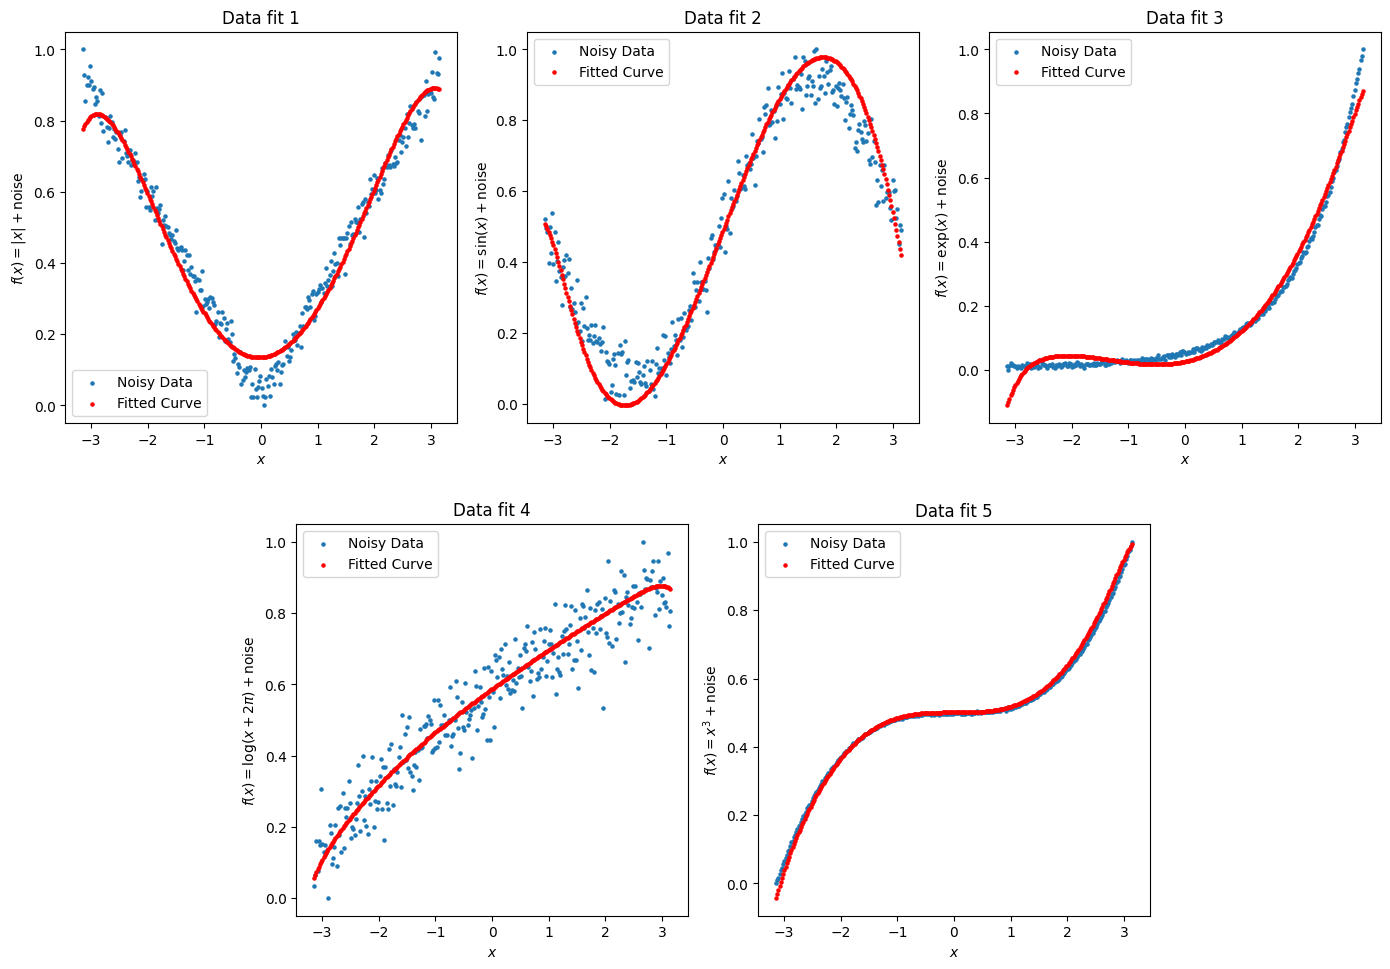

In [6]:
fit = plt.figure(figsize=(14, 10))
gs = plt.GridSpec(2, 12)

Y_preds = [model.predict(x, verbose = 0) for model in M]
y_labels = [
    r'$f(x) = |x| + \text{noise}$',
    r'$f(x) = \sin(x) + \text{noise}$',
    r'$f(x) = \exp(x) + \text{noise}$',
    r'$f(x) = \log(x+2\pi) + \text{noise}$',
    r'$f(x) = x^3 + \text{noise}$'
]

for i in range(5):
    if i < 3:
        ax = plt.subplot(gs[0, 4 * i:4 * i + 4])
    else:
        # Center the bottom plots by shifting them to the right
        ax = plt.subplot(gs[1, 4 * (i - 3) + 2:4 * (i - 3) + 6])
    
    y = Y[i]
    y_pred = Y_preds[i]
    ax.scatter(x, y, s=5, label="Noisy Data")
    ax.scatter(x, y_pred, s=5, label='Fitted Curve', color='r')
    ax.set_title(f'Data fit {i+1}')
    ax.set_xlabel(r'$x$') 
    ax.set_ylabel(y_labels[i])
    ax.legend()
    ax.set_box_aspect(1)

plt.tight_layout()
fit.savefig('fits.png')
plt.show()

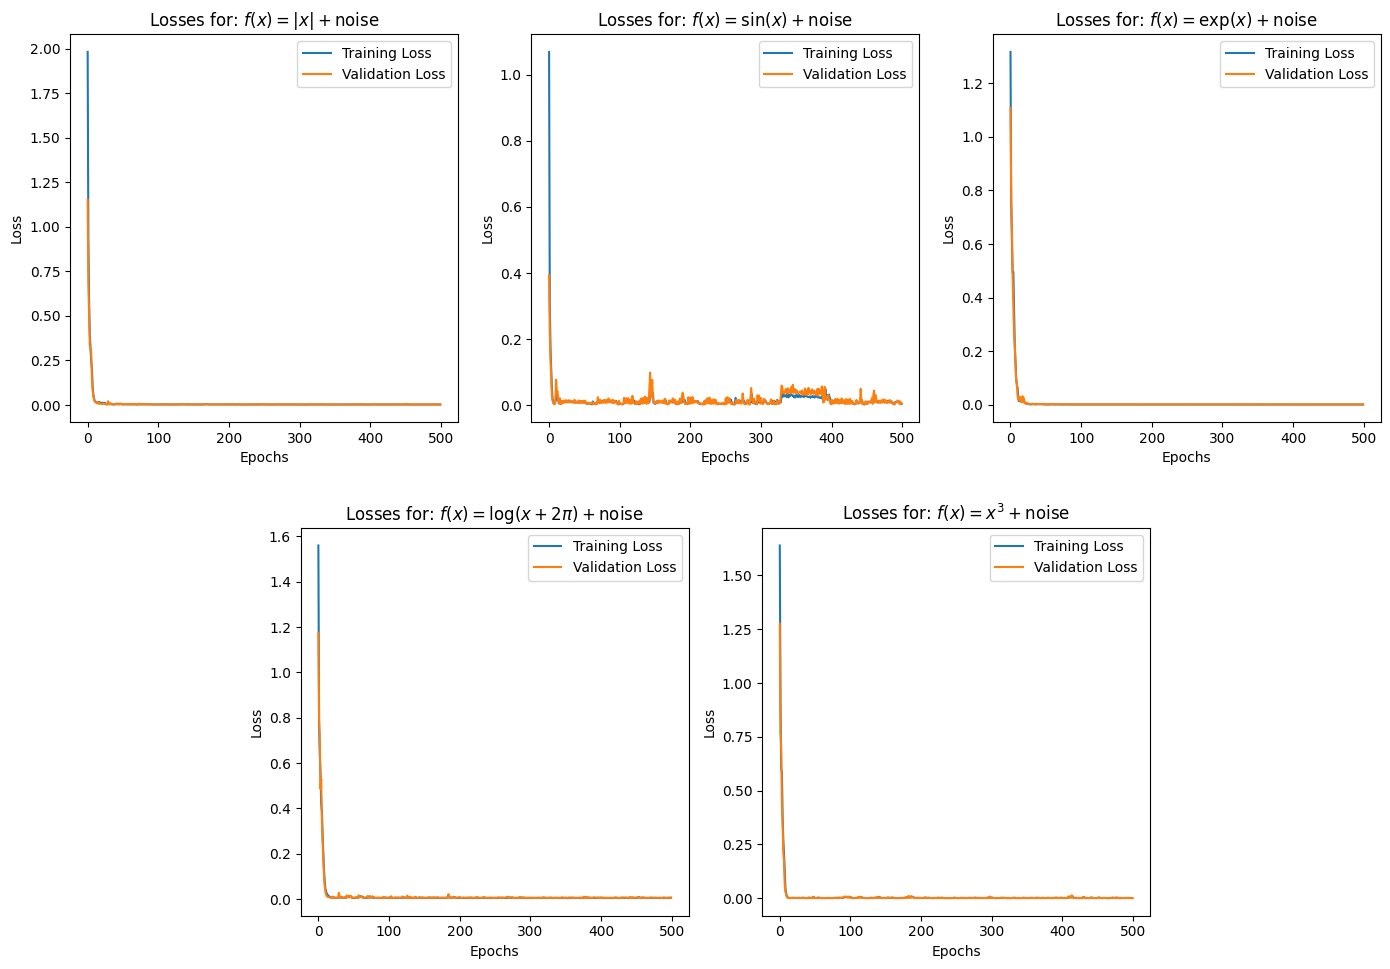

In [7]:
cost = plt.figure(figsize=(14, 10))
gs = plt.GridSpec(2, 12)

for i in range(5):
    if i < 3:
        ax = plt.subplot(gs[0, 4 * i:4 * i + 4])
    else:
        # Center the bottom plots by shifting them to the right
        ax = plt.subplot(gs[1, 4 * (i - 3) + 2:4 * (i - 3) + 6])
    
    ax.plot(H[i].history['loss'], label='Training Loss')
    ax.plot(H[i].history['val_loss'], label='Validation Loss')
    ax.set_title("Losses for: " + y_labels[i])
    ax.set_xlabel('Epochs') 
    ax.set_ylabel('Loss')
    ax.legend()
    ax.set_box_aspect(1)

plt.tight_layout()
cost.savefig('mse_with_val.png')
plt.show()

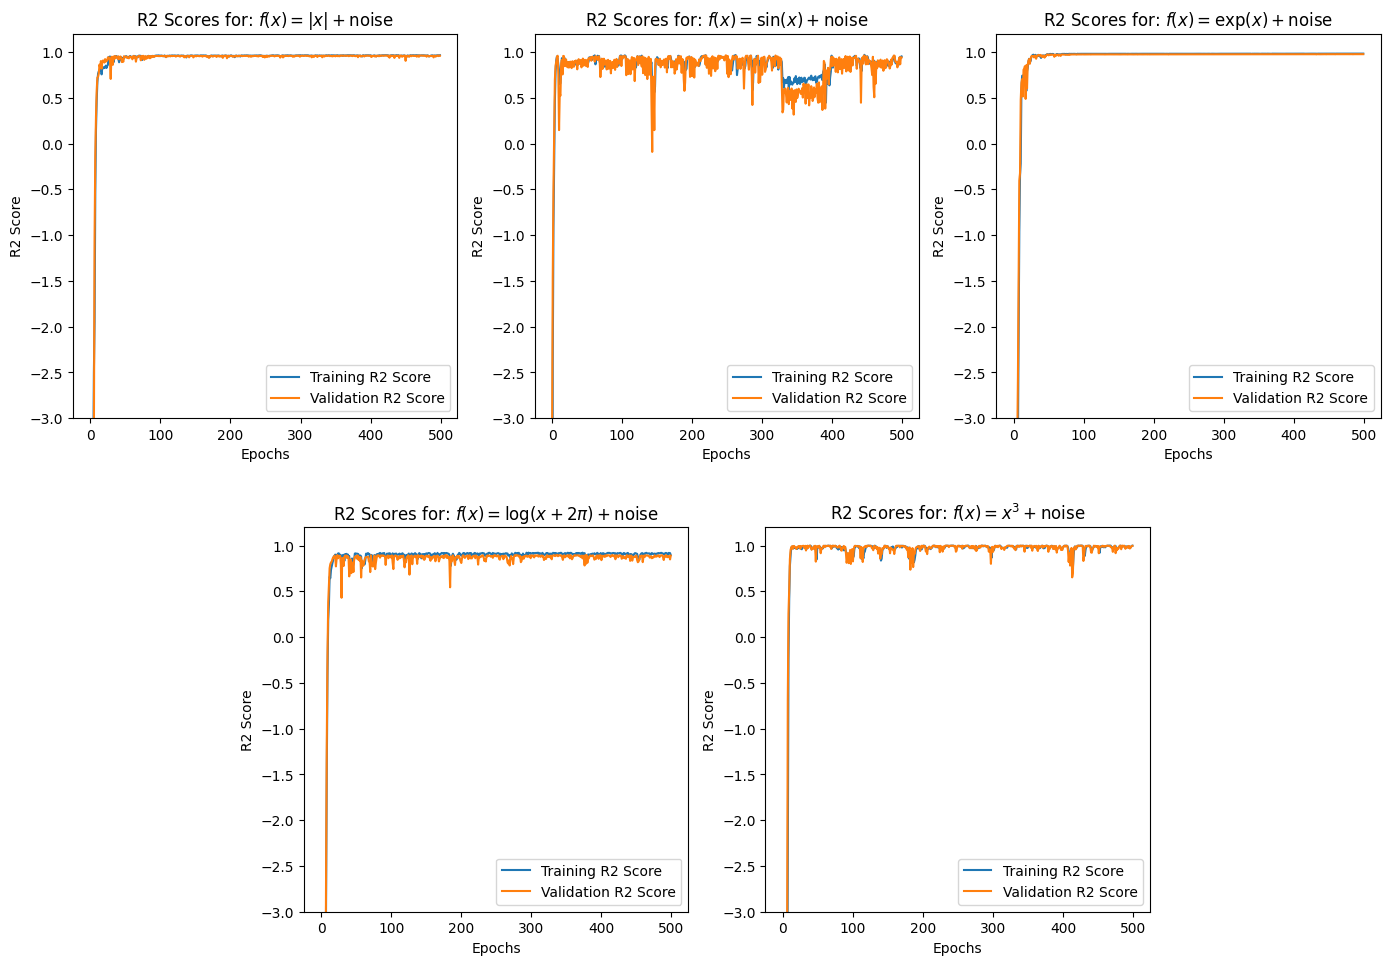

In [8]:
r2 = plt.figure(figsize=(14, 10))
gs = plt.GridSpec(2, 12)

for i in range(5):
    if i < 3:
        ax = plt.subplot(gs[0, 4 * i:4 * i + 4])
    else:
        # Center the bottom plots by shifting them to the right
        ax = plt.subplot(gs[1, 4 * (i - 3) + 2:4 * (i - 3) + 6])
    
    ax.plot(H[i].history['r2_score'], label='Training R2 Score')
    ax.plot(H[i].history['val_r2_score'], label='Validation R2 Score')
    ax.set_title("R2 Scores for: " + y_labels[i])
    ax.set_xlabel('Epochs') 
    ax.set_ylabel('R2 Score')
    ax.set_ybound(-3,1.2)
    ax.legend()
    ax.set_box_aspect(1)

plt.tight_layout()
r2.savefig('r2_with_val.png')
plt.show()

In [9]:
# Train the model
X = np.hstack((x, np.zeros(x.shape)))
classical_results = []
layers = [2,3,2,2,2]
for i in range(5):
    classical_results.append(qnn.train_classical_model(X, Y[i], i+1, learning_rate=rates[i], num_layers=layers[i], epochs=500))
cH, cM = zip(*classical_results)

Training on fold 5 complete.
Training Complete.
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cp_layer_53 (CPLayer)       (None, 2)                 5         
                                                                 
 cp_layer_54 (CPLayer)       (None, 2)                 5         
                                                                 
 extract_x_layer_24 (Extrac  (None, 1)                 0         
 tXLayer)                                                        
                                                                 
Total params: 10 (40.00 Byte)
Trainable params: 10 (40.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


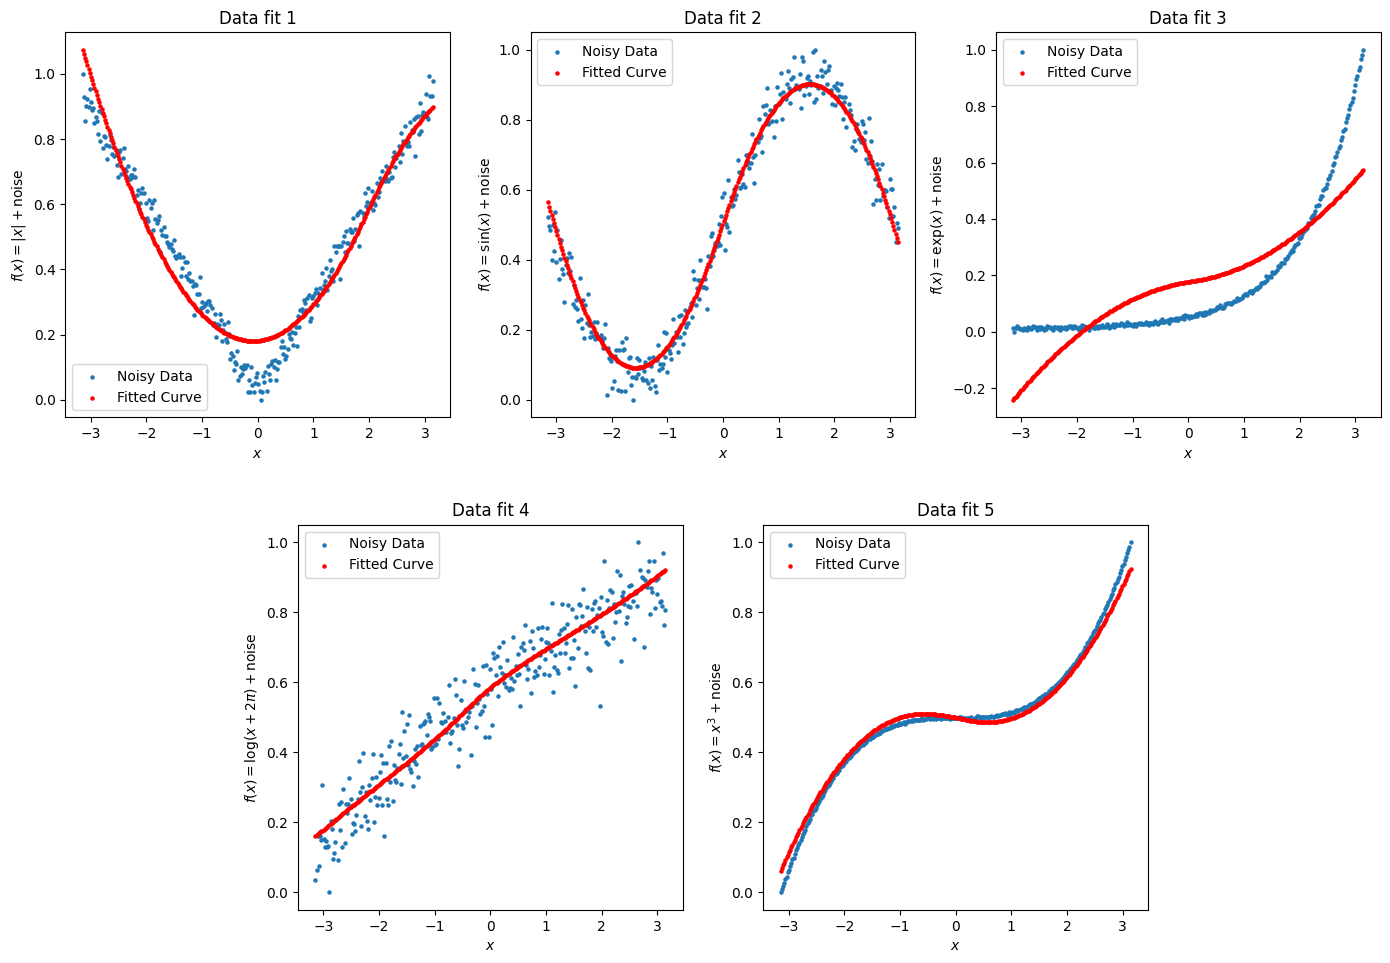

In [10]:
cfit = plt.figure(figsize=(14, 10))
gs = plt.GridSpec(2, 12)

Yc_preds = [model.predict(X, verbose = 0) for model in cM]
y_labels = [
    r'$f(x) = |x| + \text{noise}$',
    r'$f(x) = \sin(x) + \text{noise}$',
    r'$f(x) = \exp(x) + \text{noise}$',
    r'$f(x) = \log(x+2\pi) + \text{noise}$',
    r'$f(x) = x^3 + \text{noise}$'
]

for i in range(5):
    if i < 3:
        ax = plt.subplot(gs[0, 4 * i:4 * i + 4])
    else:
        # Center the bottom plots by shifting them to the right
        ax = plt.subplot(gs[1, 4 * (i - 3) + 2:4 * (i - 3) + 6])
    
    y = Y[i]
    y_pred = Yc_preds[i]
    ax.scatter(x, y, s=5, label="Noisy Data")
    ax.scatter(x, y_pred, s=5, label='Fitted Curve', color='r')
    ax.set_title(f'Data fit {i+1}')
    ax.set_xlabel(r'$x$') 
    ax.set_ylabel(y_labels[i])
    ax.legend()
    ax.set_box_aspect(1)

plt.tight_layout()
cfit.savefig('fits_classical.png')
plt.show()

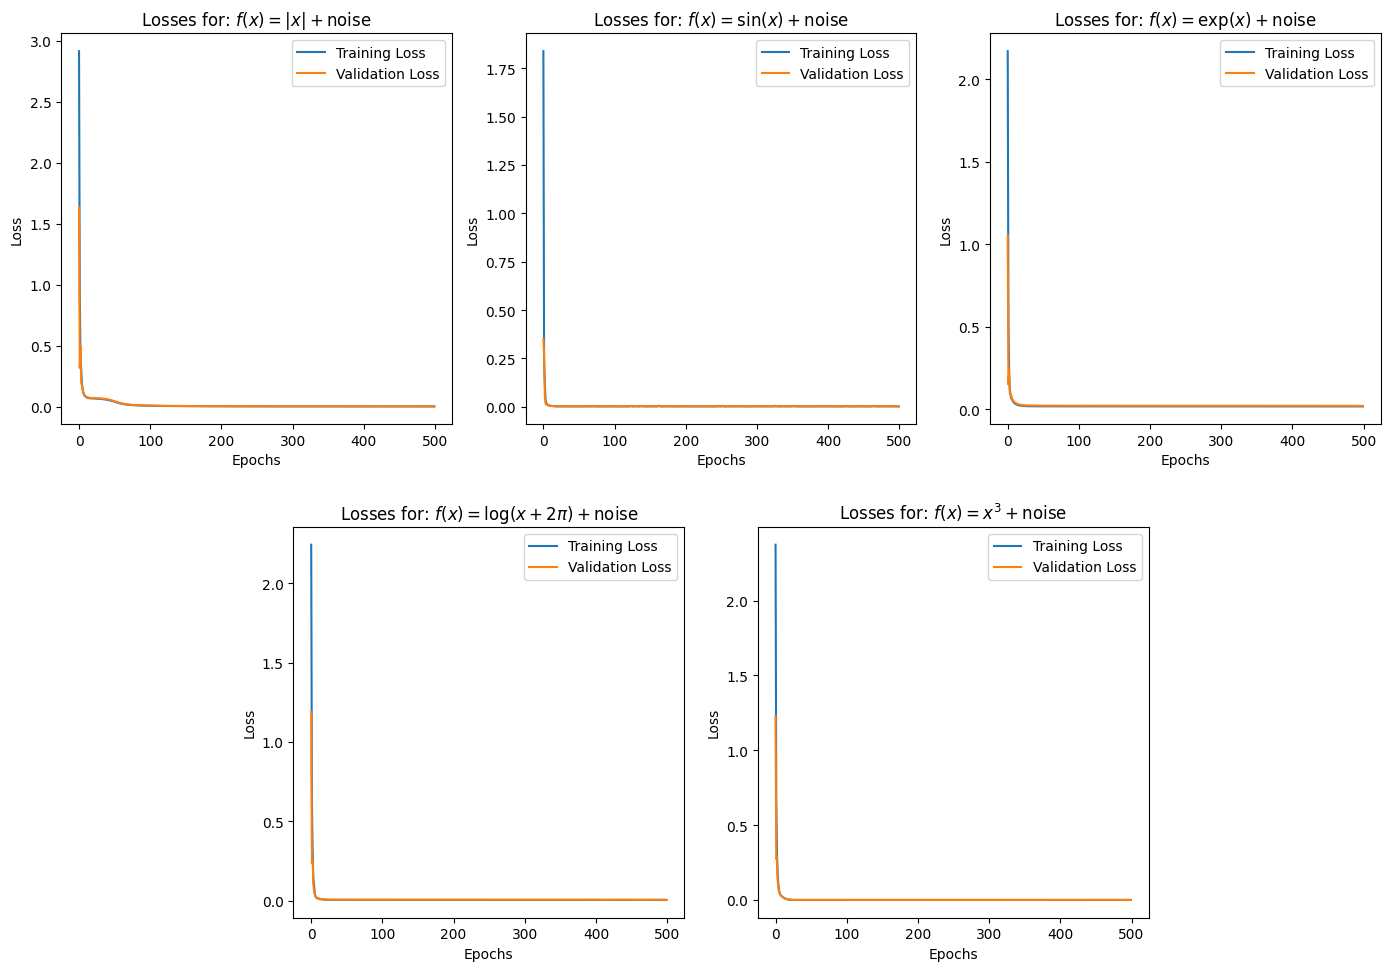

In [11]:
ccost = plt.figure(figsize=(14, 10))
gs = plt.GridSpec(2, 12)

for i in range(5):
    if i < 3:
        ax = plt.subplot(gs[0, 4 * i:4 * i + 4])
    else:
        # Center the bottom plots by shifting them to the right
        ax = plt.subplot(gs[1, 4 * (i - 3) + 2:4 * (i - 3) + 6])
    
    ax.plot(cH[i].history['loss'], label='Training Loss')
    ax.plot(cH[i].history['val_loss'], label='Validation Loss')
    ax.set_title("Losses for: " + y_labels[i])
    ax.set_xlabel('Epochs') 
    ax.set_ylabel('Loss')
    ax.legend()
    ax.set_box_aspect(1)

plt.tight_layout()
ccost.savefig('mse_with_val_classical.png')
plt.show()

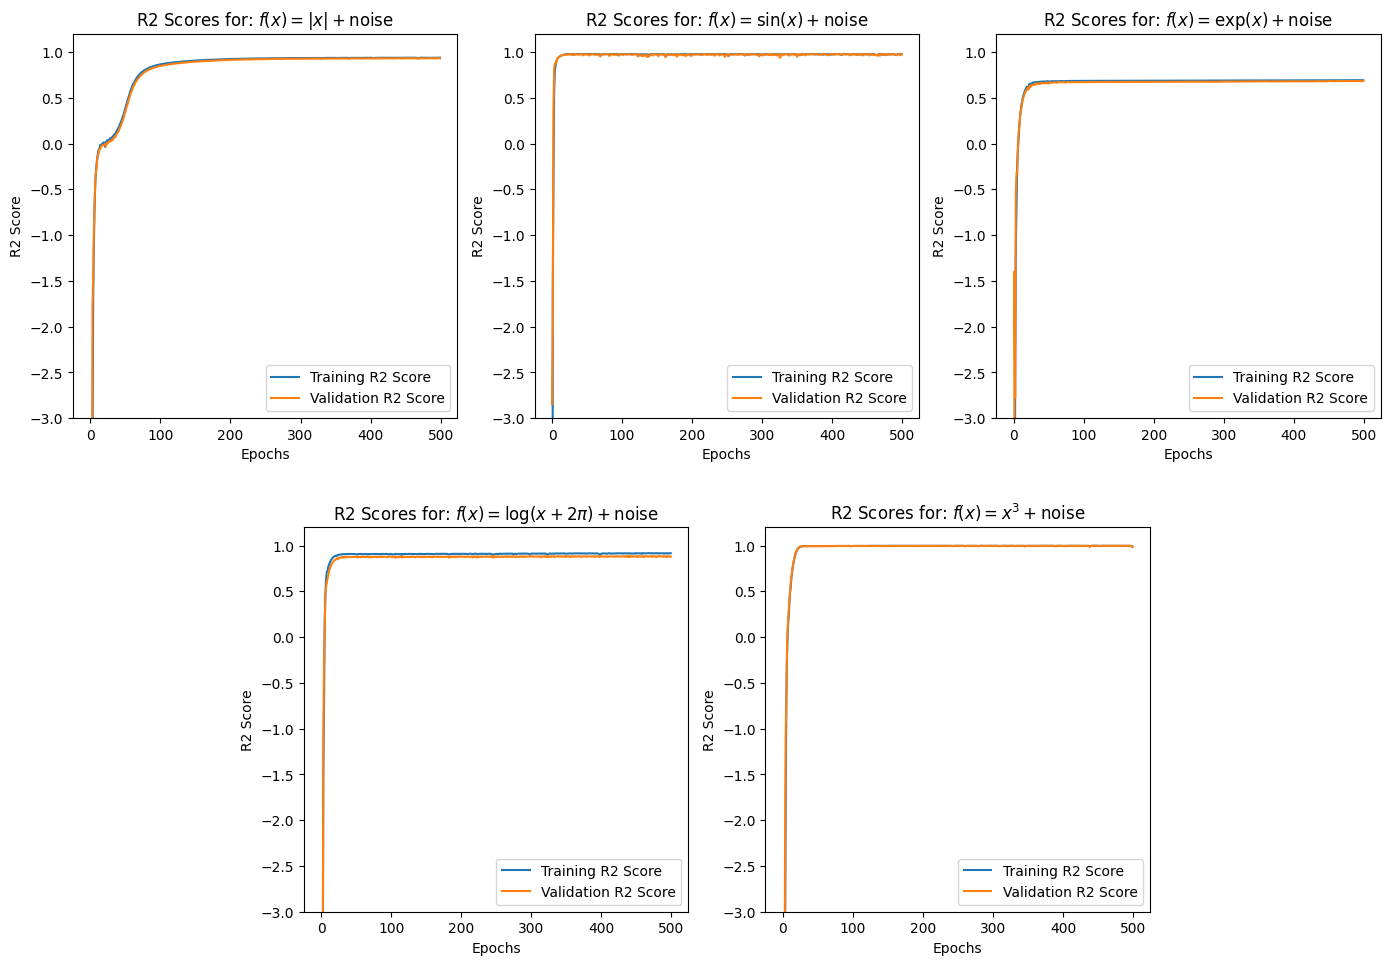

In [12]:
cr2 = plt.figure(figsize=(14, 10))
gs = plt.GridSpec(2, 12)

for i in range(5):
    if i < 3:
        ax = plt.subplot(gs[0, 4 * i:4 * i + 4])
    else:
        # Center the bottom plots by shifting them to the right
        ax = plt.subplot(gs[1, 4 * (i - 3) + 2:4 * (i - 3) + 6])
    
    ax.plot(cH[i].history['r2_score'], label='Training R2 Score')
    ax.plot(cH[i].history['val_r2_score'], label='Validation R2 Score')
    ax.set_title("R2 Scores for: " + y_labels[i])
    ax.set_xlabel('Epochs') 
    ax.set_ylabel('R2 Score')
    ax.set_ybound(-3,1.2)
    ax.legend()
    ax.set_box_aspect(1)

plt.tight_layout()
cr2.savefig('r2_with_val_classical.png')
plt.show()

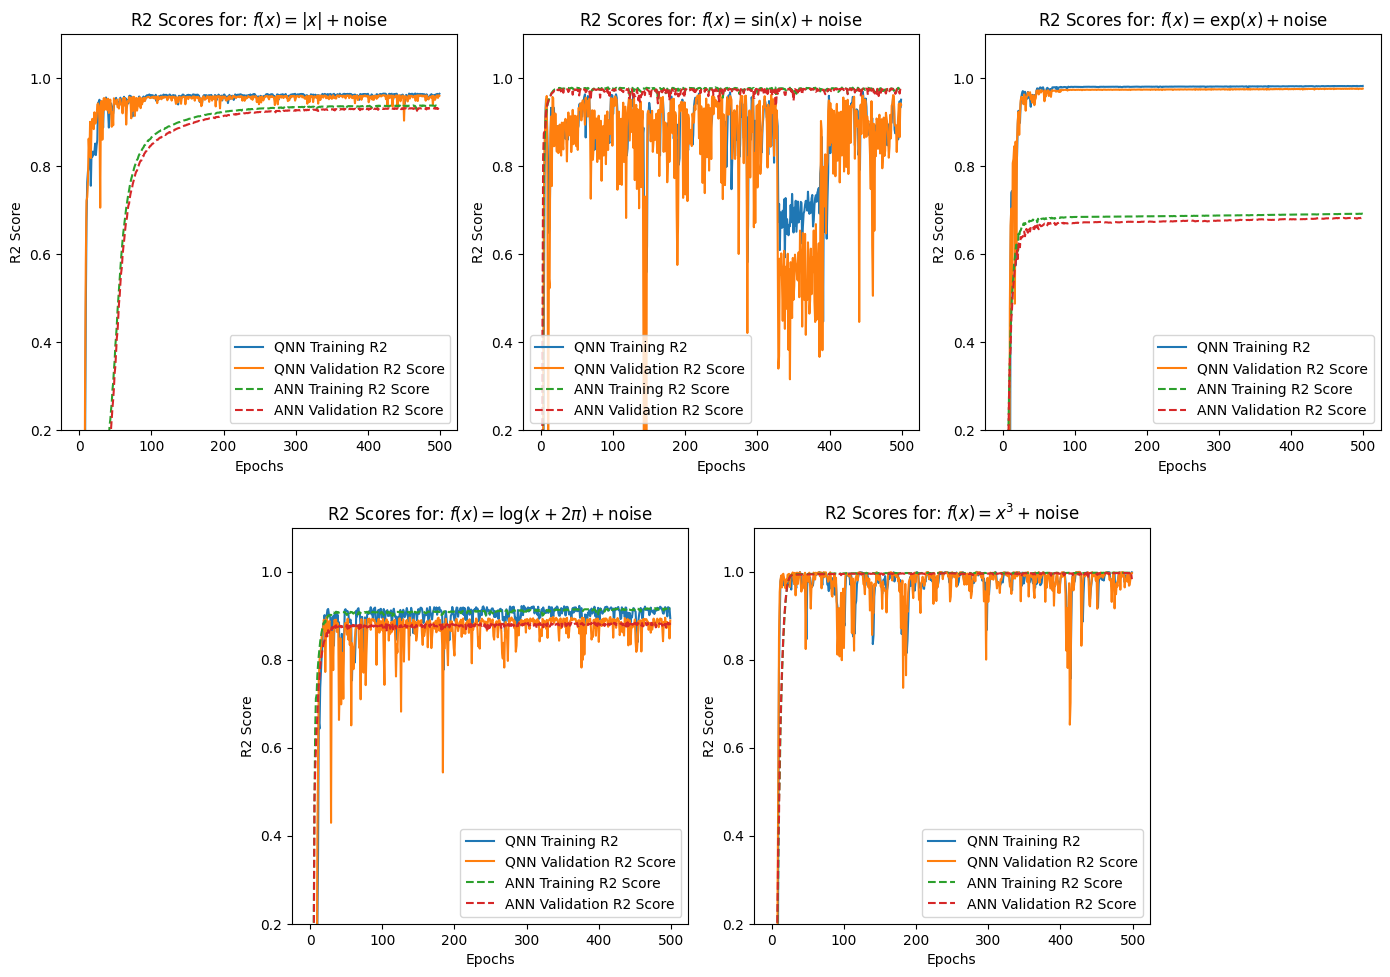

In [13]:
r2_cf = plt.figure(figsize=(14, 10))
gs = plt.GridSpec(2, 12)

for i in range(5):
    if i < 3:
        ax = plt.subplot(gs[0, 4 * i:4 * i + 4])
    else:
        # Center the bottom plots by shifting them to the right
        ax = plt.subplot(gs[1, 4 * (i - 3) + 2:4 * (i - 3) + 6])
    
    ax.plot(H[i].history['r2_score'], label='QNN Training R2')
    ax.plot(H[i].history['val_r2_score'], label='QNN Validation R2 Score')
    ax.plot(cH[i].history['r2_score'], label='ANN Training R2 Score', ls='--')
    ax.plot(cH[i].history['val_r2_score'], label='ANN Validation R2 Score', ls='--')
    ax.set_title("R2 Scores for: " + y_labels[i])
    ax.set_xlabel('Epochs') 
    ax.set_ylabel('R2 Score')
    ax.set_ybound(0.2,1.1)
    ax.legend()
    ax.set_box_aspect(1)

plt.tight_layout()
r2_cf.savefig('r2_comparison.png')
plt.show()

In [14]:
# Train the model
LH = []
layers = [1,2,5,7,10]
for nums in layers:
    LH.append(qnn.train_model(x, Y[4], 0, learning_rate=rates[4], num_layers=nums, cutoff_dim=20, epochs=500)[0])

Training on fold 5 complete.
Training Complete.
Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 QuantumEncoding (QEncoder)  (None, 20, 1)             0         
                                                                 
 QuantumLayer_1 (QLayer)     (None, 20, 1)             6         
                                                                 
 QuantumLayer_2 (QLayer)     (None, 20, 1)             6         
                                                                 
 QuantumLayer_3 (QLayer)     (None, 20, 1)             6         
                                                                 
 QuantumLayer_4 (QLayer)     (None, 20, 1)             6         
                                                                 
 QuantumLayer_5 (QLayer)     (None, 20, 1)             6         
                                                                 
 Quan

In [15]:
DH = []
dims = [5,10,15,20,25]
for cutoff in dims:
    DH.append(qnn.train_model(x, Y[4], 0, learning_rate=rates[4], num_layers=2, cutoff_dim=cutoff, epochs=500)[0])

Training on fold 5 complete.
Training Complete.
Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 QuantumEncoding (QEncoder)  (None, 25, 1)             0         
                                                                 
 QuantumLayer_1 (QLayer)     (None, 25, 1)             6         
                                                                 
 QuantumLayer_2 (QLayer)     (None, 25, 1)             6         
                                                                 
 QuantumDecoding (QDecoder)  (None,)                   0         
                                                                 
Total params: 12 (48.00 Byte)
Trainable params: 12 (48.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


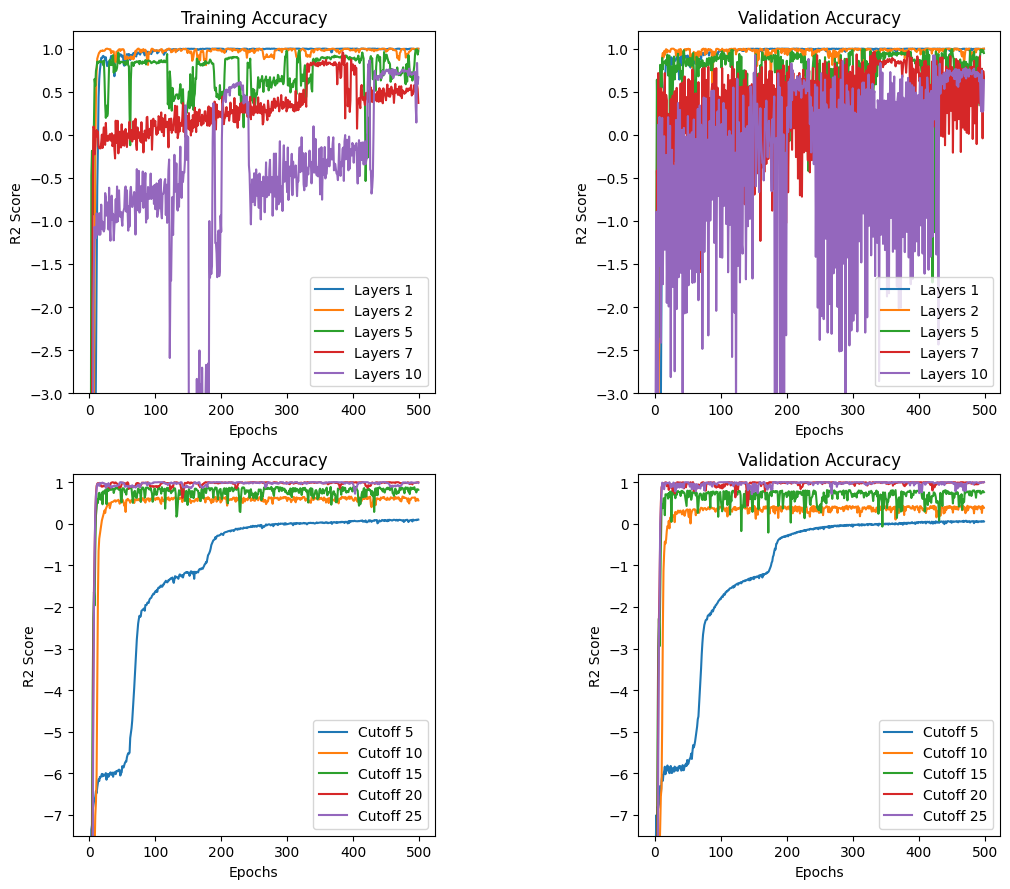

In [16]:
vars = plt.figure(figsize=(12, 9))
gs = plt.GridSpec(2, 2)

# Lists and keys to plot
history_dict = [
    (LH, 'r2_score'),
    (LH, 'val_r2_score'),
    (DH, 'r2_score'),
    (DH, 'val_r2_score')
]

#plt.title("QNN fitting accuracy for " + r'$f(x) = x^3$')

# Create 4 subplots
for i, (data_list, key) in enumerate(history_dict):
    ax = vars.add_subplot(gs[i // 2, i % 2])
    
    # Plot all objects from the list
    for history in data_list:
        ax.plot(history.history[key])
    
    ax.set_title("Training Accuracy" if i % 2 == 0 else "Validation Accuracy")
    ax.set_xlabel('Epochs')
    ax.set_ylabel('R2 Score')
    ax.legend([f'Layers {L}' if i < 2 else f'Cutoff {D}' for L, D in zip(layers, dims)])
    if i < 2:
        ax.set_ybound(-3.0,1.2)
    else:
        ax.set_ybound(-7.5,1.2)
    ax.set_box_aspect(1)

plt.tight_layout()
vars.savefig('variations.png')
plt.show()

In [17]:
# Train the model
cLH = []
new_layers = [1,2,5,7,10]
for nums in new_layers:
    cLH.append(qnn.train_classical_model(X, Y[4], 0, learning_rate=rates[4], num_layers=nums, epochs=500)[0])

Training on fold 5 complete.
Training Complete.
Model: "sequential_124"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cp_layer_170 (CPLayer)      (None, 2)                 5         
                                                                 
 cp_layer_171 (CPLayer)      (None, 2)                 5         
                                                                 
 cp_layer_172 (CPLayer)      (None, 2)                 5         
                                                                 
 cp_layer_173 (CPLayer)      (None, 2)                 5         
                                                                 
 cp_layer_174 (CPLayer)      (None, 2)                 5         
                                                                 
 cp_layer_175 (CPLayer)      (None, 2)                 5         
                                                                 
 cp_

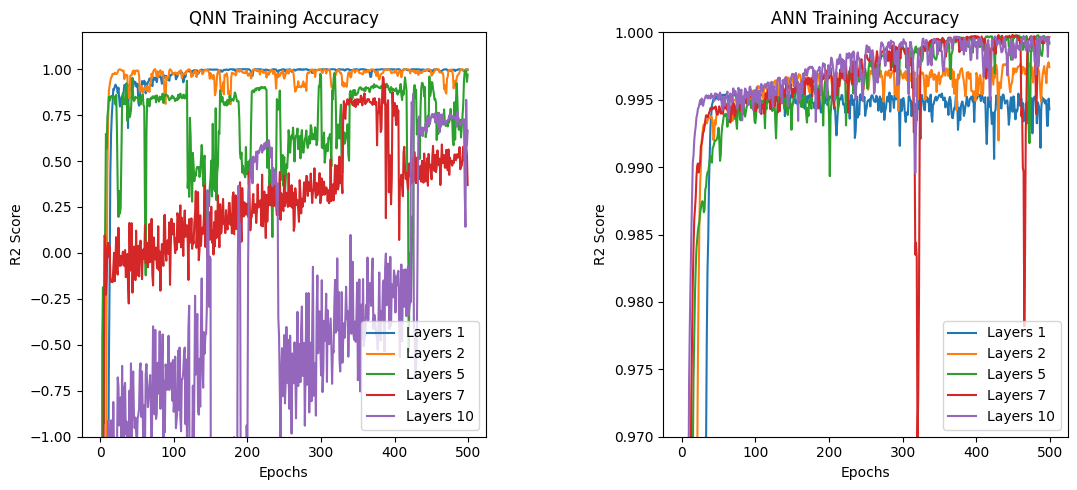

In [18]:
cfs, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Lists and keys to plot
history_dict = [
    (LH, 'r2_score', 'val_r2_score'),
    (cLH, 'r2_score', 'val_r2_score')
]

for i, (data_list, train_key, val_key) in enumerate(history_dict):
    ax = ax1 if i == 0 else ax2
    
    for j, history in enumerate(data_list):
        ax.plot(history.history[train_key], label=f'Layers {new_layers[j]}')
    
    ax.set_title("QNN Training Accuracy" if i == 0 else "ANN Training Accuracy")
    ax.set_xlabel('Epochs')
    ax.set_ylabel('R2 Score')
    ax.legend()
    if i == 0:
        ax.set_ybound(-1.0,1.2)
    else:
        ax.set_ybound(0.97,1.0)
    ax.set_box_aspect(1)

plt.tight_layout()
cfs.savefig('train_comparison.png')
plt.show()

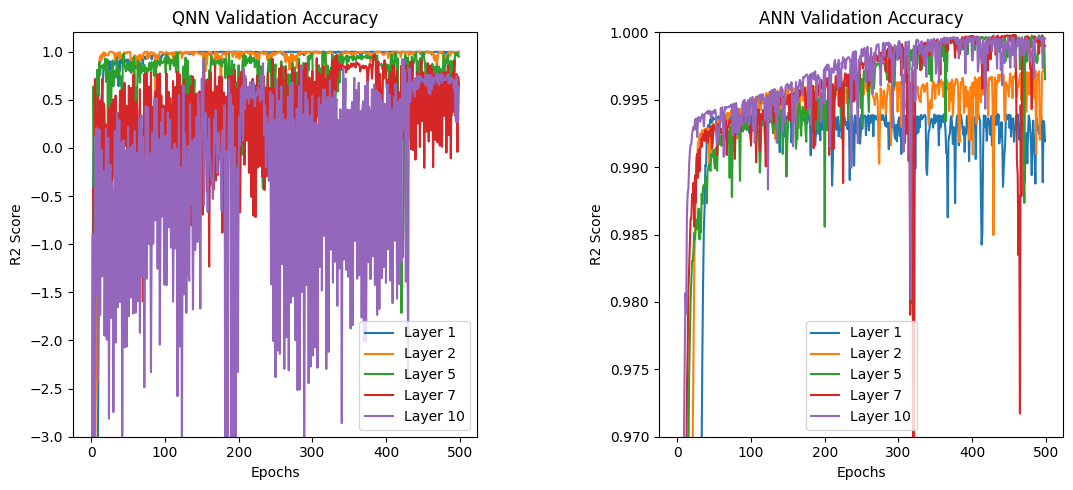

In [19]:
tcfs, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

for i, (data_list, train_key, val_key) in enumerate(history_dict):
    ax = ax1 if i == 0 else ax2
    
    for j, history in enumerate(data_list):
        ax.plot(history.history[val_key], label=f'Layer {new_layers[j]}')
    
    ax.set_title("QNN Validation Accuracy" if i == 0 else "ANN Validation Accuracy")
    ax.set_xlabel('Epochs')
    ax.set_ylabel('R2 Score')
    ax.legend()
    if i == 0:
        ax.set_ybound(-3.0,1.2)
    else:
        ax.set_ybound(0.97,1.0)
    ax.set_box_aspect(1)

plt.tight_layout()
tcfs.savefig('test_comparison.png')
plt.show()